This notebook is all about coming up with ways to asses how good a job PyVBMC does. 

To start, we'll state the differential equation of interest, get integration working for that equation, and run a PyVBMC optimize routine on it.


The differential equation:

$$\ddot{x} = -x -ax^b$$

generalized to deal with all values of b:

$$\ddot{x} = -x - sign(x)a|x|^b$$

$0<a\leq0.5$

 $1\leq b \leq 5$

In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [2]:
def diffyqs(X, t, a,b):
    x, vx = X[0], X[1]
    dx = vx
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dx, dv]

initial_condition = [0.0, 3.5]
t = np.arange(0,10,0.05)

a_true = 0.2 
b_true = 4.0
sol = odeint(diffyqs, initial_condition, t, args=(a_true,b_true))
x_true = sol[:,1]

a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

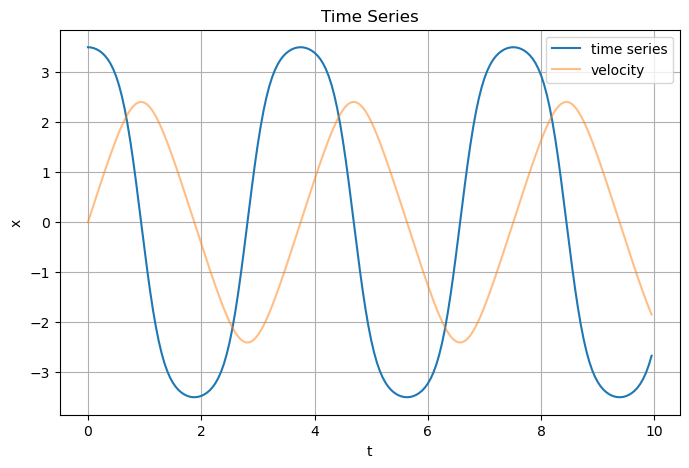

In [3]:
def plot_ts(t,ts,v, mode = 0):
    plt.figure(figsize=(8,5))
    if mode == 0:
        plt.plot(t,ts)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()
        plt.show()
    else:
        plt.plot(t,ts, label = 'time series')
        plt.plot(t,v, label = 'velocity', alpha = 0.5)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.grid()
        plt.show()

plot_ts(t,sol[:, 1],sol[:, 0],1)

In [5]:
def log_likelihood(theta):
    a,b = theta
    #a_true = 0.2 
    #b_true = 4.0
    #sol = odeint(diffyqs, initial_condition, t, args=(a_true,b_true))
    #x_true = sol[:,1]
    sol = odeint(diffyqs, initial_condition, t, args=(a,b)) # get solution of ODE with current choice of params
    return -np.sum((sol[:,1] - x_true)**2) # normal distribution sorta

In [6]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), a_min)  # Lower bounds
LB[0][1] = b_min
UB = np.full((1, D), a_max)  # Upper bounds
UB[0][1] = b_max

PLB = np.copy(LB) + 0.05
PUB = np.copy(UB) - 0.05

x0 = np.full((1, D), a_true+0.1) # starting point for inference   # 1.5 * np.ones((1, D))
x0[0][1] = b_true + 0.1

print(LB,PLB,PUB,UB,'x0:',x0)

[[0. 1.]] [[0.05 1.05]] [[0.45 4.95]] [[0.5 5. ]] x0: [[0.3 4.1]]


In [7]:
prior = SplineTrapezoidal(LB, PLB, PUB, UB)
#prior = [scs.norm(loc = 0.3,scale = 0.3),scs.norm(loc = 3.9,scale = 0.3)]
options = {
    "display": "off"
}

In [8]:
def old_euclidean_metric(vp,truth_array, n_samples = int(2e6),original = False): 

    Xs, _ = vp.sample(n_samples) # sample vp
    scaler = StandardScaler() # create scaler (don't bother centering)
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    if original:
        return np.linalg.norm(scaler.inverse_transform(mean-truth_scaled))
    else:
        return np.linalg.norm(mean-truth_scaled)

In [9]:
def euclidean_metric(vp,truth_array, n_samples = int(2e6),original = False): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)

    set original to true to respect the original distances
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    if original:
        return np.linalg.norm(scaler.inverse_transform(mean-truth_scaled))
    else:
        return np.linalg.norm(mean-truth_scaled)

# call the function on our current example
# print(euclidean_metric(vp,np.array([[a,b]])),euclidean_metric(vp,np.array([[a,b]]),original =True),old_euclidean_metric(vp,np.array([[a,b]])))

In [10]:
metric_list = []
for i in range(3):
    vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) # initialize VMBC object
    vp, results = vbmc.optimize(); # do optimization (might take a while)
    metric_list.append(euclidean_metric(vp,np.array([[a_true,b_true]])))

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.815 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7.000 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.929 +/-0.001.


In [17]:
metric_list = []

vbmc0 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) 
vbmc1 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) 
vbmc2 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) 
vp0, results0 = vbmc0.optimize();
vp1, results1 = vbmc1.optimize();
vp2, results2 = vbmc2.optimize();
metric_list.append(euclidean_metric(vp0,np.array([[a_true,b_true]])))
metric_list.append(euclidean_metric(vp1,np.array([[a_true,b_true]])))
metric_list.append(euclidean_metric(vp2,np.array([[a_true,b_true]])))

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.768 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7.190 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.920 +/-0.000.


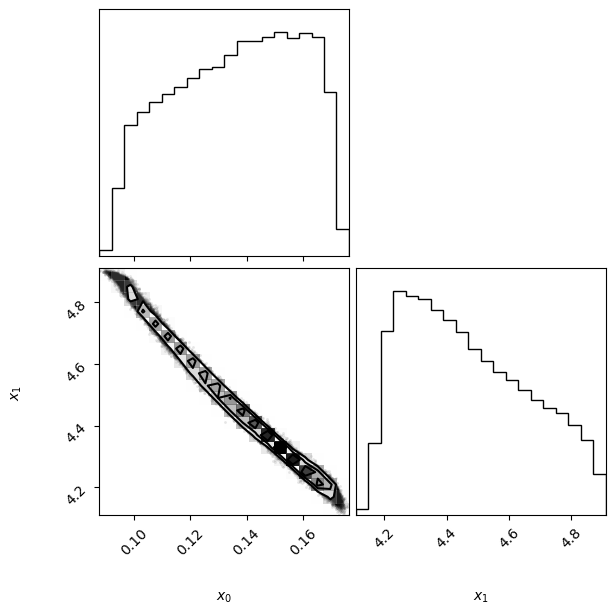

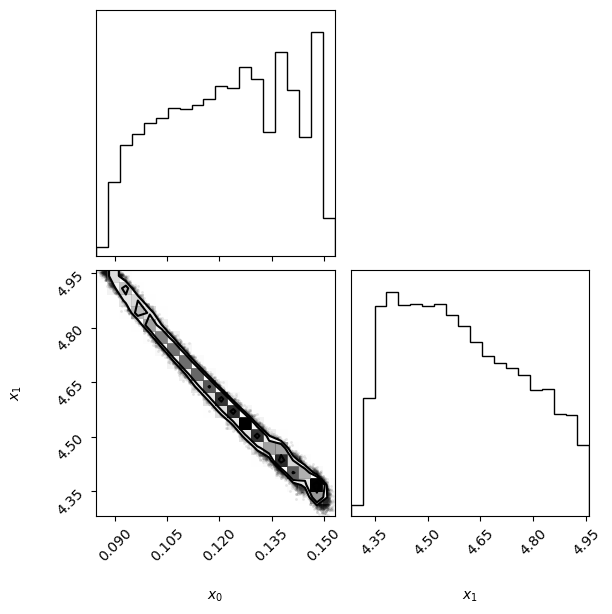

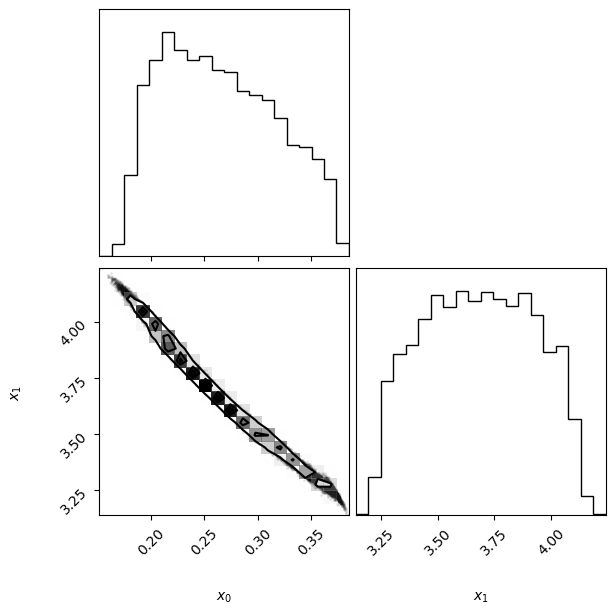

In [19]:
vp0.plot();
vp1.plot();
vp2.plot();

In [42]:
Xs, _ = vp.sample(int(1e5)) # sample vp
pdf_mode = scs.mode(Xs,keepdims = True)
print(pdf_mode[0])

[[0.10503475 3.5405087 ]]


In [47]:
import scipy.stats as scs
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

def CI_2D(vp,pdf,true_value,step = 0.05,n_samples = int(5e5)):
    # do sampling, take mode of samples
    Xs, _ = vp.sample(n_samples) # sample vp
    pdf_mode = scs.mode(Xs,keepdims = True)[0]
    a0,b0 = pdf_mode[0][0] - step, pdf_mode[0][0] + step
    a1,b1 = pdf_mode[0][1] - step, pdf_mode[0][1] + step
    I = 0
    def check_if_in_CI(true_value,a0,b0,a1,b1):
        if a0 <= true_value[0] and true_value[0] <= b0 \
            and a1 <= true_value[1] and true_value[1] <= b1:
            return False
        else:
            return True
    while check_if_in_CI(true_value,a0,b0,a1,b1):
        I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
        a0 -= step
        b0 += step
        a1 -= step
        b1 += step
    return I

print("1 std CI:$",CI_2D(vp,vp.pdf,[0.5,0.5],0.01))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 2

In [58]:
vp_simple = lambda x,y: vp.pdf(np.array([[x,y]]))
I = integrate.dblquad(vp_simple, 0, 0.5, 0, 5)

In [59]:
I

(0.0, 0)

In [20]:
print(metric_list)

[0.9026327340635936, 1.3850534735223259, 0.3822030783204535]


^^^ this produces wildly different results, but the one below doesent. Why?

In [14]:
metric_list = []
for i in range(5):
    metric_list.append(euclidean_metric(vp,np.array([[a_true,b_true]])))

In [15]:
print(metric_list)

[0.06200373714828558, 0.06204462929321517, 0.06118000065158068, 0.0617727203084112, 0.06111011149952557]


In [ ]:
# points = []
# solutions = []
# N = 1
# grid = np.zeros((N,N))
# for i,a in enumerate(np.linspace(0.0,1.0,N)):
#     for j,b in enumerate(np.linspace(1.0,5.0,N)):
#         points.append([a,b])
#         sol = odeint(diffyqs, initial_condition, t, args=(a,b))
#         x_true = sol[:,1]
#         solutions.append(x_true)  

# #solutions = solutions[0:5]
# plt.figure(figsize=(12,6))
# for i,sol in enumerate(solutions):
#     plt.plot(t,sol, lw = 1,label = str(points[i]))
# plt.xlabel('t')
# plt.ylabel('x')
# plt.legend()  
# plt.show()  

In [27]:
vp0.pdf(np.array([[0.2,4.1]]))

array([[7.48966114e-142]])

In [ ]:
def CI_1D(pdf,true_value,step):
    a,b = pdf_mode - step, pdf_mode + step
    I = 0
    def check_if_in_CI(true_value,a,b):
        if a <= true_value and true_value <= b:
            return False
        else:
            return True
    while check_if_in_CI(true_value,a,b):
        I = integrate(pdf,a,b)
        a -= step
        b += step
    return I

# Heatmap data with euclidean metric

In [ ]:
N = 2
grid = np.zeros((N,N))
bad_grid = np.copy(grid)
old_grid = np.copy(grid)
solutions = []
pairs = []
for i,a in enumerate(np.linspace(a_min,a_max,N)):     # a will be y axis in grid
    for j,b in enumerate(np.linspace(b_min,b_max,N)): # b will be x axis in grid
        sol_true = odeint(diffyqs, initial_condition, t, args=(a,b))
        x_true = sol_true[:,1]
        solutions.append(x_true)
        vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
        vp, results = vbmc.optimize();
        pairs.append([a,b])
        metric = euclidean_metric(vp,np.array([[a,b]]))
        grid[i,j] = metric
        bad_grid[i,j] = euclidean_metric(vp,np.array([[a,b]]), original = True)
        old_grid[i,j] = old_euclidean_metric(vp,np.array([[a,b]]))

#np.array(grid).tofile('metrics_grid.csv', sep = ',')
#np.array(metrics).tofile('metrics.csv', sep = ',')

In [ ]:
grid

In [ ]:
sns.heatmap(grid)

## Everything below here is garbage, ignore it please

In [ ]:
# this is stupid and janky as hell
# big_list = []
# for i in range(len(samples)):
#     for j in range(2):
#         big_list.append(np.array(samples[i])[:,j])
# df = pd.DataFrame(big_list).T

In [ ]:
scaler = StandardScaler()
scaler.fit(samples_df)
scaled_data = scaler.transform(samples_df) # scale samplesb
scaled_data = pd.DataFrame(scaled_data)

In [ ]:
def euclidean_metric(scaled_samples_array,truth_array,scaler): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)
    """
    mean = np.array([scaled_samples_array[0].mean(),scaled_samples_array[1].mean()]) # compute mean of scaled_samples_array
    truth_scaled = scaler.transform(truth_array) # scale true data
    return #np.linalg.norm(mean-truth_scaled) # return distance between mean and truth

In [ ]:
scaled_samples_array = np.array([scaled_data[0],scaled_data[0+1]])
scaled_samples_array[0]
#euclidean_metric(scaled_samples_array,np.array([[0.2,4]]),scaler)

scaler.transform(np.array([[0.2,4]]))

In [ ]:
metrics_grid = np.zeros((N,N))
count = 0
for i,a in enumerate(np.linspace(a_min,a_max,N)):     # a will be y axis in grid
    for j,b in enumerate(np.linspace(b_min,b_max,N)):
        scaled_samples_array = np.array([scaled_data[count],scaled_data[count+1]])
        metrics_grid[i,j] = euclidean_metric(scaled_samples_array,np.array([[a,b]]),scaler)
        count += 2

In [ ]:
metrics_grid